This notebook serves introduces a simplified end-to-end modeling __deep learning__ pipeline: (1) data prep, (2) modeling, (3) evaluation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from chaosbench import dataset, config, utils, criterion

## Deep Learning
Let's build a deep learning pipeline, with a few years for training

In [3]:
# Define training/validation years (DO NOT use the year 2023, since its held-out for evaluation)
train_years = np.arange(2021, 2022)
val_years = test_years = np.arange(2022, 2023)

print(f'training years: {train_years}')
print(f'validation years: {val_years}')

training years: [2021]
validation years: [2022]


In [4]:
# Specify variables to be used for training
## More details on the variables can be found at https://leap-stc.github.io/ChaosBench/dataset.html
## We have atmos_vars, ocean_vars (optional), land_vars (optional)
TARGET_VARS = ['t-850', 'z-500', 'q-700'] # MANDATORY for evaluation

## Additional variables for feature engineering
atmos_vars = ['u-850', 'v-850'] ## Let's try adding wind speed 
land_vars = [] ## Empty for now...
ocean_vars = [] ## Empty for now...

In [5]:
# Build the dataset (for training and validation, both on different years)
lead_time = 44

train_dataset = dataset.S2SObsDataset(
    years=train_years, # Years for training
    lead_time=lead_time, # Number of days ahead as target
    atmos_vars=TARGET_VARS + atmos_vars, # Atmospheric variables; if not given will use ALL 60 variables
    land_vars=land_vars, # Land variables
    ocean_vars=ocean_vars # Ocean variables
)

val_dataset = dataset.S2SObsDataset(
    years=val_years, # Years for validation
    lead_time=lead_time, # Number of days ahead as target
    atmos_vars=TARGET_VARS + atmos_vars, # Atmospheric variables; if not given will use ALL 60 variables
    land_vars=land_vars, # Land variables
    ocean_vars=ocean_vars # Ocean variables
)

/burg/home/jn2808/.conda/envs/bench/lib/python3.9/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [6]:
# Let's inspect the dataset
time_idx = 0 # Define the timestep to inspect e.g., first day of the year (1st January)
timestamp, val_x, val_y = val_dataset[time_idx]

print(f'input shape: (n_variables, latitude, longitude): {val_x.shape}')
print(f'input shape: (future_steps, n_variables, latitude, longitude): {val_y.shape}')

input shape: (n_variables, latitude, longitude): torch.Size([5, 121, 240])
input shape: (future_steps, n_variables, latitude, longitude): torch.Size([1, 5, 121, 240])


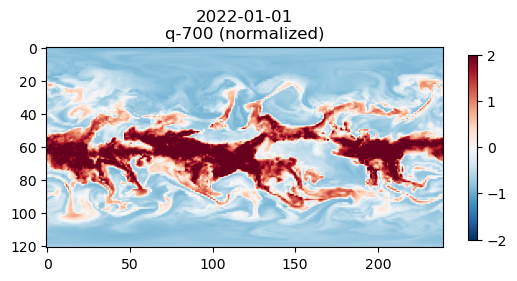

In [7]:
# Let's plot the dataset 
# e.g., humidity, q, at 700-hPa level --> which measures near surface wetness and can be useful to track drought!

time_idx = 0 # Define the timestep to inspect e.g., first day of the validation dataset 
param_name = 'q-700' # Define the variable to be inspected e.g., temperature t at pressure level 850 hPA

## Get the dataset
timestamp, val_x, val_y = val_dataset[time_idx]

## Get the index to subset
param_idx = val_dataset.era5_idx.index(
     utils.get_param_level_idx(*param_name.split('-')) # Get the variable index for plotting
)

## Plot!
plt.imshow(val_x[param_idx], cmap='RdBu_r', vmin=-2, vmax=2)

plt.colorbar(shrink=0.5)
plt.title(f'{utils.convert_time(timestamp)}\n{param_name} (normalized)')
plt.show();

In [8]:
# Now let's build a simple deep learning model
in_variables = len(TARGET_VARS) + len(atmos_vars) + len(land_vars) + len(ocean_vars)
out_variables = len(TARGET_VARS) + len(atmos_vars) + len(land_vars) + len(ocean_vars)
size = [121, 240]

model = nn.Sequential(
    nn.Conv2d(in_variables, in_variables*2, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_variables*2, in_variables*4, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_variables*4, in_variables*2, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(in_variables*2, out_variables, kernel_size=3, padding=1)
)

model = model.to(config.device) ## We can also leverage GPU by transfering the data to GPU (if available) with .to()

In [9]:
# One easy way is to use DataLoader function provided by torch
# This can also be useful for subsequent demonstration for training more complicated models
from torch.utils.data import DataLoader

batch_size = 32 # This specifies the number of batches e.g., number of days to be loaded simultaneously
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)


In [10]:
# You can further specify e.g., optimizer and loss function to train your deep model
# More info: https://pytorch.org/docs/stable/optim.html
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001) ## Stochastic Gradient Descent optimizer
loss_fn = torch.nn.MSELoss() ## Mean-squared error function


In [11]:
# Let's try training the model for 5 epochs (~3 minutes)
epochs = 5 ## Number of epoch

for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    
    ## Training cycle
    model.train() 
    for i, data in enumerate(train_dataloader):

        timestamp, train_x, train_y = data
        train_x, train_y = train_x.to(config.device), train_y.to(config.device)

        optimizer.zero_grad() ## Clear gradients
        
        ## Make prediction
        preds_y = model(train_x)
        preds_y = preds_y.reshape(train_y.shape)
        
        ## Compute loss
        loss = loss_fn(preds_y, train_y)
        
        ## Propagate gradient 
        loss.backward()
        
        ## Update weights
        optimizer.step()
        
    print(f'Training Loss: {loss.item()}')
    
    
    ## Evaluation cycle
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(val_dataloader): 
            
            timestamp, val_x, val_y = data
            val_x, val_y = val_x.to(config.device), val_y.to(config.device)
            
            ## Make prediction
            preds_y = model(val_x)
            preds_y = preds_y.reshape(val_y.shape)
            
            ## Compute loss
            loss = loss_fn(preds_y, val_y)
            
        print(f'Validation Loss: {loss.item()}')

Epoch: 0
Training Loss: 0.9108163118362427
Validation Loss: 0.8601901531219482
Epoch: 1
Training Loss: 0.7224550247192383
Validation Loss: 0.6610246300697327
Epoch: 2
Training Loss: 0.5963390469551086
Validation Loss: 0.593968391418457
Epoch: 3
Training Loss: 0.5600413084030151
Validation Loss: 0.5644176006317139
Epoch: 4
Training Loss: 0.5576610565185547
Validation Loss: 0.5475614070892334
CPU times: user 20min 47s, sys: 13min 41s, total: 34min 28s
Wall time: 3min 6s


In [12]:
# Let's use our model to make prediction!
time_idx = 0
timestamp, val_x, val_y = val_dataset[time_idx]
val_x, val_y = val_x.to(config.device), val_y.to(config.device)
            
## Make prediction
preds_y = model(val_x)
preds_y = preds_y.reshape(val_y.shape)

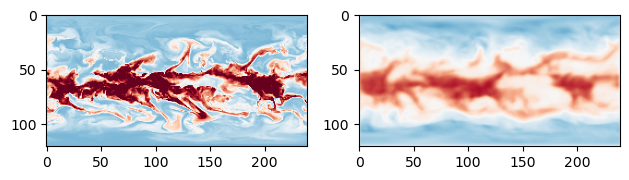

In [13]:
# Now let's put them side-by-side
## Say let's see the performance for q-700 prediction

param_name = 'q-700'
param_idx = val_dataset.era5_idx.index(
     utils.get_param_level_idx(*param_name.split('-')) # Get the variable index for plotting
)

f, ax = plt.subplots(1,2)
ax[0].imshow(val_y[0,param_idx].detach().cpu(), cmap='RdBu_r', vmin=-2, vmax=2) ## Truth
ax[1].imshow(preds_y[0,param_idx].detach().cpu(), cmap='RdBu_r', vmin=-2, vmax=2) ## prediction

plt.tight_layout()
plt.show();

In [14]:
# Now let's try computing its criterion (root mean-squared error)
rmse = criterion.RMSE(lat_adjusted=False) ## no latitude adjustment, i.e., normal RMSE
loss = rmse(preds_y, val_y)

print(f'rmse loss: {loss}')

rmse loss: 0.7217102646827698


You can now go ahead and play around with using different variables, years, or models to train on!